# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Customer Behavior Analysis and Prediction Pipeline

This project analyzes customer behavior and predicts outcomes based on marketing offers. The pipeline includes data loading, cleaning, merging, feature engineering, exploratory data analysis (EDA), and machine learning modeling.

## **1. Import Libraries**

The following libraries are imported for data manipulation, visualization, and machine learning:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
%matplotlib inline


## 2. Load Data
The load_data() function loads the datasets from JSON files:

In [2]:
def load_data():
    """
    Load the datasets from JSON files.
    Returns:
        portfolio, profile, transcript DataFrames.
    """
    portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
    profile = pd.read_json('data/profile.json', orient='records', lines=True)
    transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
    return portfolio, profile, transcript

## 3. Clean Data
The clean_data() function cleans and preprocesses the datasets:

In [3]:
def clean_data(portfolio, profile, transcript):
    """
    Clean and preprocess the datasets.
    Args:
        portfolio, profile, transcript DataFrames.
    Returns:
        Cleaned portfolio, profile, transcript DataFrames.
    """
    # Clean Portfolio Data
    portfolio['channels'] = portfolio['channels'].apply(lambda x: ','.join(x))
    portfolio = pd.get_dummies(portfolio, columns=['channels'], prefix='', prefix_sep='')

    # Clean Profile Data
    profile['age'] = profile['age'].apply(lambda x: profile['age'].median() if x == 118 else x)
    profile['gender'] = profile['gender'].fillna('U')  # U for unknown
    profile['income'] = profile['income'].fillna(profile['income'].median())
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

    # Clean Transcript Data
    transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id') or x.get('offer_id'))
    transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))
    transcript.drop(columns=['value'], inplace=True)

    return portfolio, profile, transcript

## 4. Merge Data
The merge_data() function merges the datasets into a single DataFrame:

In [4]:
def merge_data(portfolio, profile, transcript):
    """
    Merge the datasets into a single DataFrame.
    Args:
        portfolio, profile, transcript DataFrames.
    Returns:
        Merged DataFrame.
    """
    merged_data = pd.merge(transcript, profile, left_on='person', right_on='id', how='left')
    merged_data = pd.merge(merged_data, portfolio, left_on='offer_id', right_on='id', how='left')
    return merged_data

## 5. Feature Engineering
The feature_engineering() function creates new features:

In [5]:
def feature_engineering(merged_data):
    """
    Perform feature engineering on the merged dataset.
    Args:
        merged_data DataFrame.
    Returns:
        DataFrame with additional features.
    """
    # Create age groups
    merged_data['age_group'] = pd.cut(merged_data['age'], bins=[0, 18, 35, 50, 65, 100], labels=['0-18', '19-35', '36-50', '51-65', '66-100'])
   
    # Create income groups
    merged_data['income_group'] = pd.cut(merged_data['income'], bins=[0, 30000, 60000, 90000, 120000], labels=['0-30k', '30k-60k', '60k-90k', '90k-120k'])
   
    # Create gender groups
    merged_data['gender_group'] = merged_data['gender'].apply(lambda x: 'Other' if x not in ['M', 'F'] else x)
   
    return merged_data




## 6. Exploratory Data Analysis (EDA)
The perform_eda() function generates visualizations for EDA:

In [6]:



def perform_eda(merged_data):
    """
    Perform exploratory data analysis and generate visualizations.
    Args:
        merged_data DataFrame.
    """
    # Age Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data['age'].dropna(), bins=30, kde=True, color='blue')
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

    # Income Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data['income'].dropna(), bins=30, kde=True, color='green')
    plt.title('Income Distribution')
    plt.xlabel('Income')
    plt.ylabel('Frequency')
    plt.show()

    # Gender Distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='gender_group', data=merged_data, palette='Set2')
    plt.title('Gender Distribution')
    plt.xlabel('Gender Group')
    plt.ylabel('Count')
    plt.show()

    # Offer Completion Rates by Demographic Group
    completion_rates = merged_data[merged_data['event'] == 'offer completed'].groupby(
        ['gender_group', 'age_group', 'income_group', 'offer_type']
    ).size().unstack(fill_value=0)

    plt.figure(figsize=(12, 8))
    sns.heatmap(completion_rates, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Number of Completions'})
    plt.title('Offer Completion Rates by Demographic Group', fontsize=16)
    plt.xlabel('Offer Type', fontsize=12)
    plt.ylabel('Demographic Group', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 7. Prepare Data for Modeling
The prepare_data() function prepares data for regression and classification tasks:

In [7]:

def prepare_data(merged_data):
    """
    Prepare data for regression and classification modeling.
    Args:
        merged_data DataFrame.
    Returns:
        X_reg, y_reg, X_clf, y_clf DataFrames.
    """
    # For Regression (Predicting Amount)
    transaction_data = merged_data[merged_data['event'] == 'transaction']
   
    # Drop identifier columns if they exist
    columns_to_drop_reg = ['event', 'amount', 'person', 'id', 'offer_id']
    columns_to_drop_reg = [col for col in columns_to_drop_reg if col in transaction_data.columns]
    X_reg = transaction_data.drop(columns=columns_to_drop_reg)
   
    y_reg = transaction_data['amount']
   
    # One-hot encode categorical variables
    X_reg = pd.get_dummies(X_reg, columns=['gender_group', 'age_group', 'income_group'], drop_first=True)

    # Handle missing and infinite values in X_reg
    X_reg = X_reg.fillna(0)
    X_reg = X_reg.replace([np.inf, -np.inf], 1e10)

    # For Classification (Predicting Offer Completion)
    offer_data = merged_data[merged_data['event'].isin(['offer received', 'offer viewed', 'offer completed'])]
    offer_data['target'] = (offer_data['event'] == 'offer completed').astype(int)

    # Drop identifier columns if they exist
    columns_to_drop_clf = ['event', 'target', 'person', 'id', 'offer_id']
    columns_to_drop_clf = [col for col in columns_to_drop_clf if col in offer_data.columns]
    X_clf = offer_data.drop(columns=columns_to_drop_clf)
   
    y_clf = offer_data['target']

    # One-hot encode categorical variables
    X_clf = pd.get_dummies(X_clf, columns=['gender_group', 'age_group', 'income_group', 'offer_type'], drop_first=True)

    # Handle missing and infinite values in X_clf
    X_clf = X_clf.fillna(0)
    X_clf = X_clf.replace([np.inf, -np.inf], 1e10)

    return X_reg, y_reg, X_clf, y_clf

## 8. Train and Evaluate Models


In [8]:

def train_regression_model_with_random_search(X_train_reg, y_train_reg, X_test_reg, y_test_reg):
    """
    Train and evaluate a RandomForestRegressor using RandomizedSearchCV.
    Args:
        X_train_reg, y_train_reg, X_test_reg, y_test_reg DataFrames.
    """
    # Drop non-numeric columns (e.g., identifiers)
    non_numeric_columns = X_train_reg.select_dtypes(include=['object']).columns
    if len(non_numeric_columns) > 0:
        print(f"Dropping non-numeric columns: {non_numeric_columns}")
        X_train_reg = X_train_reg.drop(columns=non_numeric_columns)
        X_test_reg = X_test_reg.drop(columns=non_numeric_columns)

    # Handle datetime column (convert to numeric)
    if 'became_member_on' in X_train_reg.columns:
        reference_date = pd.to_datetime('2000-01-01')
        X_train_reg['membership_days'] = (pd.to_datetime(X_train_reg['became_member_on']) - reference_date).dt.days
        X_test_reg['membership_days'] = (pd.to_datetime(X_test_reg['became_member_on']) - reference_date).dt.days
        X_train_reg.drop(columns=['became_member_on'], inplace=True)
        X_test_reg.drop(columns=['became_member_on'], inplace=True)

    # Define the parameter grid for RandomizedSearchCV
    param_dist_reg = {
        'n_estimators': [100, 200],  # Reduced range
        'max_depth': [None, 10, 20],  # Reduced range
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    # Initialize the model
    model_reg = RandomForestRegressor(random_state=42)

    # Initialize RandomizedSearchCV
    random_search_reg = RandomizedSearchCV(
        estimator=model_reg,
        param_distributions=param_dist_reg,
        n_iter=10,  # Reduced from 50 to 10
        cv=3,       # Reduced from 5 to 3
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1   # Use all available cores
    )

    # Subsample the data for faster tuning
    X_train_reg_small, _, y_train_reg_small, _ = train_test_split(X_train_reg, y_train_reg, test_size=0.5, random_state=42)

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_reg.fit(X_train_reg_small, y_train_reg_small)
    print("RandomizedSearchCV completed.")

    # Get the best model
    best_model_reg = random_search_reg.best_estimator_

    # Evaluate the best model on the full test set
    y_pred_reg = best_model_reg.predict(X_test_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)
    mae = mean_absolute_error(y_test_reg, y_pred_reg)

    print("\nRegression Results with RandomizedSearchCV:")
    print(f'Best Hyperparameters: {random_search_reg.best_params_}')
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'Mean Absolute Error: {mae}')

    # Feature Importance
    importances = best_model_reg.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train_reg.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print("\nTop 10 Features by Importance:")
    print(feature_importance_df.head(10))

def train_classification_model_with_random_search(X_train_clf, y_train_clf, X_test_clf, y_test_clf):
    """
    Train and evaluate a RandomForestClassifier using RandomizedSearchCV.
    Args:
        X_train_clf, y_train_clf, X_test_clf, y_test_clf DataFrames.
    """
    # Drop non-numeric columns (e.g., identifiers)
    non_numeric_columns = X_train_clf.select_dtypes(include=['object']).columns
    if len(non_numeric_columns) > 0:
        print(f"Dropping non-numeric columns: {non_numeric_columns}")
        X_train_clf = X_train_clf.drop(columns=non_numeric_columns)
        X_test_clf = X_test_clf.drop(columns=non_numeric_columns)

    # Handle datetime column (convert to numeric)
    if 'became_member_on' in X_train_clf.columns:
        reference_date = pd.to_datetime('2000-01-01')
        X_train_clf['membership_days'] = (pd.to_datetime(X_train_clf['became_member_on']) - reference_date).dt.days
        X_test_clf['membership_days'] = (pd.to_datetime(X_test_clf['became_member_on']) - reference_date).dt.days
        X_train_clf.drop(columns=['became_member_on'], inplace=True)
        X_test_clf.drop(columns=['became_member_on'], inplace=True)

    # Define the parameter grid for RandomizedSearchCV
    param_dist_clf = {
        'n_estimators': [100, 200],  # Reduced range
        'max_depth': [None, 10, 20],  # Reduced range
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'class_weight': ['balanced', None]
    }

    # Initialize the model
    model_clf = RandomForestClassifier(random_state=42)

    # Initialize RandomizedSearchCV
    random_search_clf = RandomizedSearchCV(
        estimator=model_clf,
        param_distributions=param_dist_clf,
        n_iter=10,  # Reduced from 50 to 10
        cv=3,       # Reduced from 5 to 3
        scoring='accuracy',
        random_state=42,
        n_jobs=-1   # Use all available cores
    )

    # Subsample the data for faster tuning
    X_train_clf_small, _, y_train_clf_small, _ = train_test_split(X_train_clf, y_train_clf, test_size=0.5, random_state=42)

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_clf.fit(X_train_clf_small, y_train_clf_small)
    print("RandomizedSearchCV completed.")

    # Get the best model
    best_model_clf = random_search_clf.best_estimator_

    # Evaluate the best model on the full test set
    y_pred_clf = best_model_clf.predict(X_test_clf)
    print("\nClassification Results with RandomizedSearchCV:")
    print(f'Best Hyperparameters: {random_search_clf.best_params_}')
    print(classification_report(y_test_clf, y_pred_clf))
    print(f'Accuracy Score: {accuracy_score(y_test_clf, y_pred_clf)}')

    # Feature Importance
    importances = best_model_clf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train_clf.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print("\nTop 10 Features by Importance:")
    print(feature_importance_df.head(10))

## 9. Main Function
The main() function orchestrates the entire pipeline:

In [9]:
def main():
    # Load data
    portfolio, profile, transcript = load_data()

    # Clean data
    portfolio, profile, transcript = clean_data(portfolio, profile, transcript)

    # Merge data
    merged_data = merge_data(portfolio, profile, transcript)

    # Feature engineering
    merged_data = feature_engineering(merged_data)

    # Perform EDA
    perform_eda(merged_data)

    # Prepare data for modeling
    X_reg, y_reg, X_clf, y_clf = prepare_data(merged_data)

    # Split data for regression
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

    # Train and evaluate regression model with RandomizedSearchCV
    train_regression_model_with_random_search(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

    # Split data for classification
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

    # Train and evaluate classification model with RandomizedSearchCV
    train_classification_model_with_random_search(X_train_clf, y_train_clf, X_test_clf, y_test_clf)

## 10. Execution
The script runs the main() function when executed:

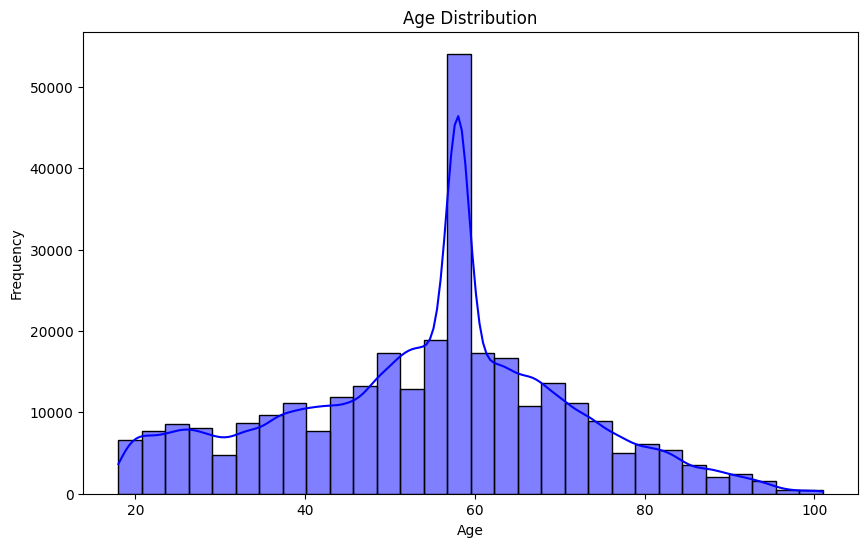

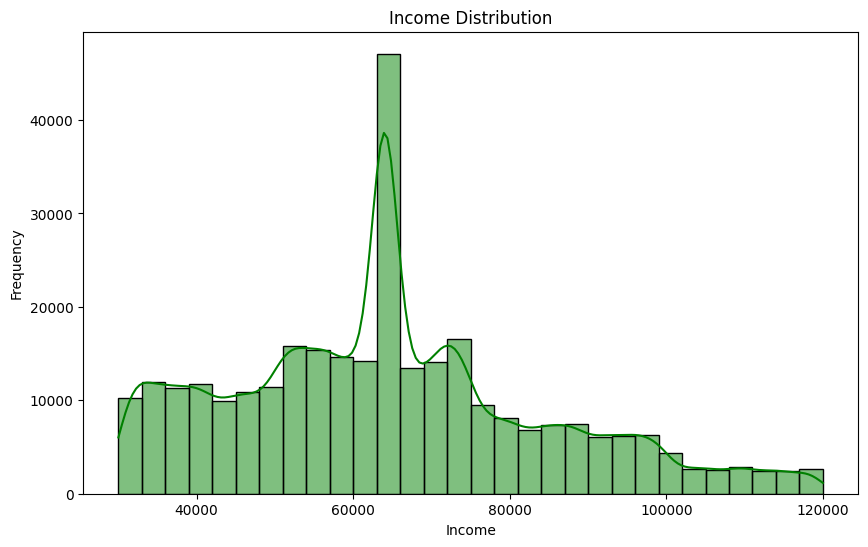

C:\Users\juliuscr\AppData\Local\Temp\ipykernel_27472\297236877.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender_group', data=merged_data, palette='Set2')


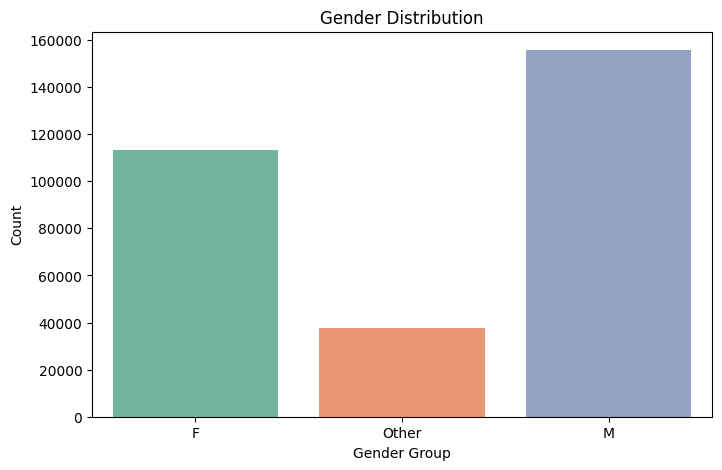

C:\Users\juliuscr\AppData\Local\Temp\ipykernel_27472\297236877.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_rates = merged_data[merged_data['event'] == 'offer completed'].groupby(


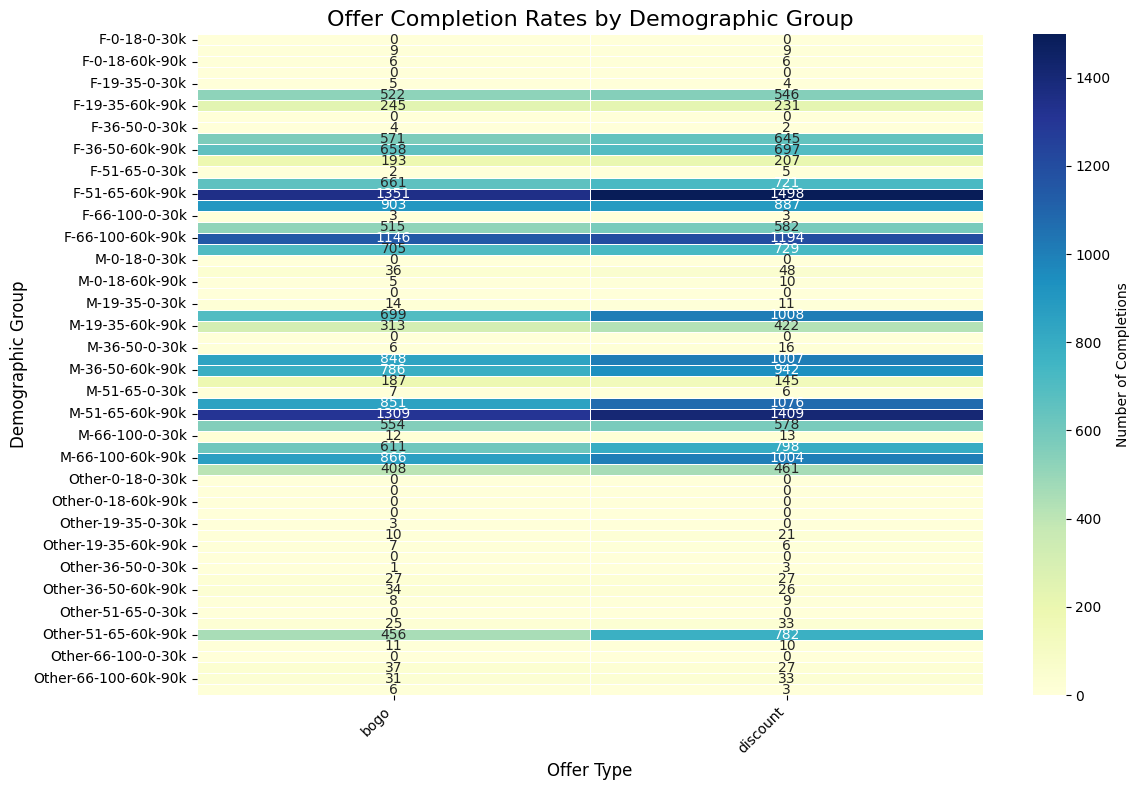

C:\Users\juliuscr\AppData\Local\Temp\ipykernel_27472\616045618.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_reg = X_reg.fillna(0)
C:\Users\juliuscr\AppData\Local\Temp\ipykernel_27472\616045618.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_data['target'] = (offer_data['event'] == 'offer completed').astype(int)
C:\Users\juliuscr\AppData\Local\Temp\ipykernel_27472\616045618.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call re

Dropping non-numeric columns: Index(['gender', 'id_x'], dtype='object')
Starting RandomizedSearchCV...
RandomizedSearchCV completed.

Regression Results with RandomizedSearchCV:
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}
Mean Squared Error: 885.2316385627464
R^2 Score: 0.06846241652700669
Mean Absolute Error: 6.6097672451524625

Top 10 Features by Importance:
                  Feature  Importance
2                  income    0.308977
21        membership_days    0.178305
0                    time    0.160162
1                     age    0.109162
20  income_group_90k-120k    0.080895
18   income_group_30k-60k    0.050785
13     gender_group_Other    0.042884
19   income_group_60k-90k    0.022136
12         gender_group_M    0.021316
16        age_group_51-65    0.007538
Dropping non-numeric columns: Index(['gender', 'id_x', 'id_y'], dtype='object')
Starting RandomizedSearchCV...


In [10]:
if __name__ == "__main__":
    main()